In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az
import xarray as xr

sns.set_style("whitegrid")

# Сравнение моделей

## Теория вопроса

### Проверка апостериорного распределения



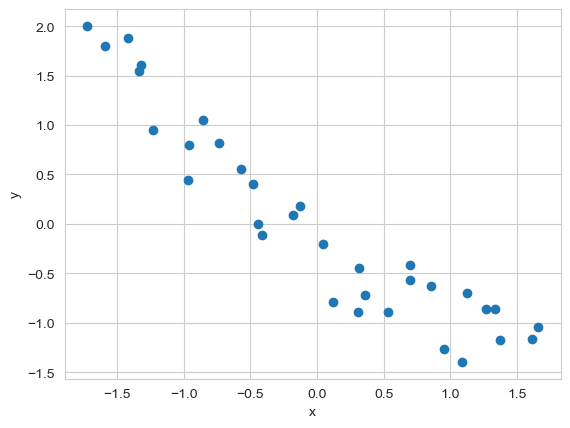

In [4]:
dummy_data = np.loadtxt('datasets/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True) ## позволяет вычесть среднее по столбцам
y_1s = (y_1 - y_1.mean()) / y_1.std()

plt.scatter(x_1s[0], y_1s)
plt.xlabel('x');
plt.ylabel('y');


In [5]:
with pm.Model() as model_l:

    x_1_obs = pm.Data('x_1_obs', x_1s[0])
    
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = pm.Deterministic("μ", α + β * x_1_obs)

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y_1s)

    trace_l = pm.sample(2000)

with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sigma=1)
    β = pm.Normal('β', mu=0, sigma=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)

    μ = pm.Deterministic("μ", α + pm.math.dot(β, x_1s))

    y_pred = pm.Normal('y_pred', mu=μ, sigma=ϵ, observed=y_1s)

    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, ϵ]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


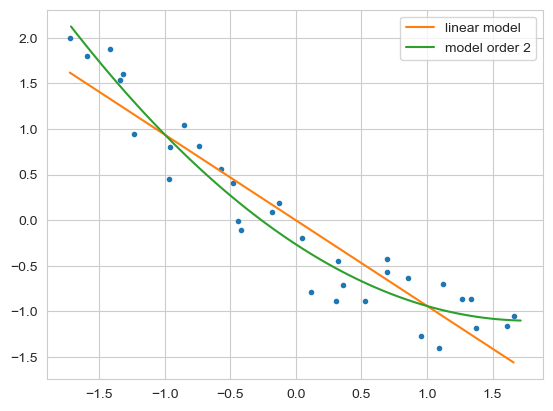

In [6]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)
x_new_p = np.linspace(x_1.min(), x_1.max(), 100)
x_new_p = np.array([x_new_p, x_new_p**2])
x_new_q = (x_new_p - x_new_p.mean(axis=1, keepdims=True))/x_new_p.std(axis=1, keepdims=True)

α_l_post = trace_l.posterior['α'].mean(['chain','draw'])
β_l_post = trace_l.posterior['β'].mean(['chain','draw'])
y_l_post = α_l_post + β_l_post *  xr.DataArray(x_new)

plt.plot(x_new, y_l_post, 'C1', label='linear model')

α_p_post = trace_p.posterior['α'].mean(['chain','draw'])
β_p_post = trace_p.posterior['β'].mean(['chain','draw'])

y_p_post = α_p_post.values + np.dot(β_p_post.values, x_new_q)

plt.plot(x_new_q[0], y_p_post, 'C2', label=f'model order {order}')

plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend();

In [7]:
with model_l:
    sample_l = pm.sample_posterior_predictive(trace_l,  var_names=['y_pred'])

with model_p:
     sample_p = pm.sample_posterior_predictive(trace_p,  var_names=['y_pred'])

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

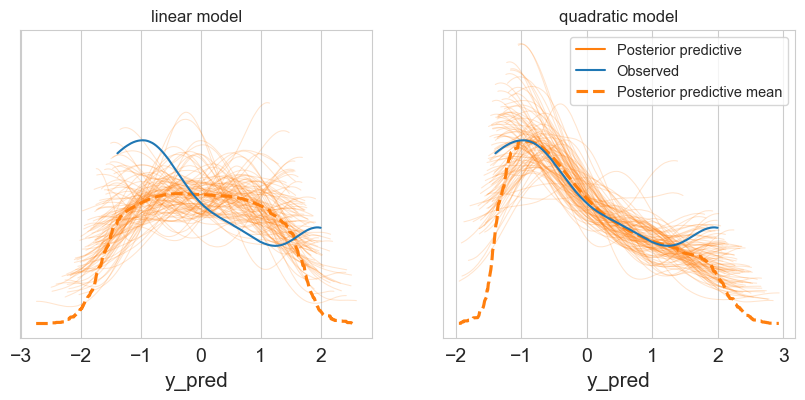

In [8]:
_, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
az.plot_ppc(sample_l, num_pp_samples=100, ax=axes[0], legend=False, colors=["C1", "C0", "C1"] )
axes[0].set_title("linear model")
az.plot_ppc(sample_p, num_pp_samples=100, ax=axes[1], colors=["C1", "C0", "C1"],  data_pairs={"y_pred": "y_pred"})
axes[1].set_title(f"quadratic model");

In [9]:
y_l  = sample_l.posterior_predictive['y_pred'].mean(['chain','draw'])
y_p  = sample_p.posterior_predictive['y_pred'].mean(['chain','draw'])

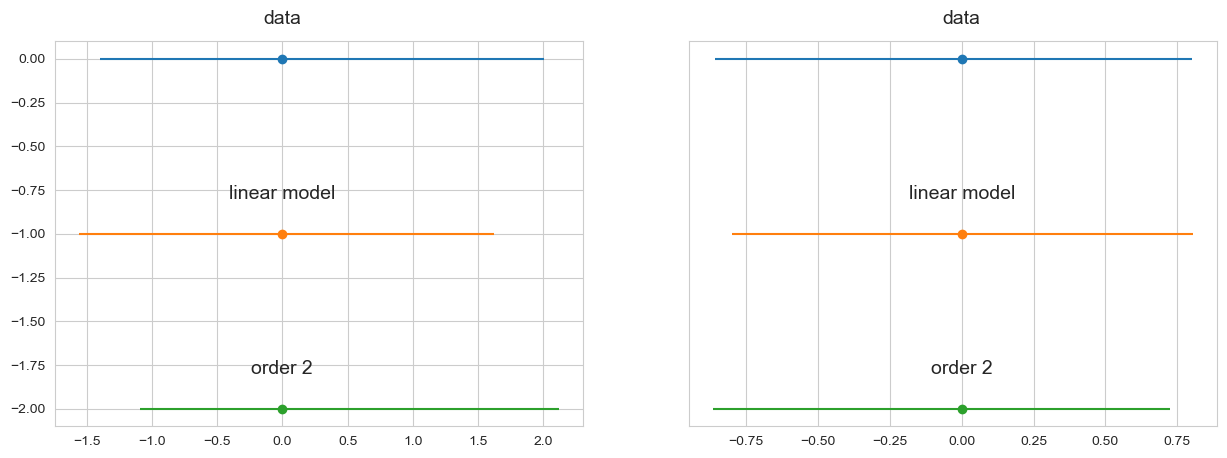

In [10]:
_, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [0, 100])
    ax1.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    ax1.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
    err = np.percentile(d, [25, 75])
    ax2.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    ax2.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
#plt.ylim([-i-0.5, 0.5])
plt.yticks([]);

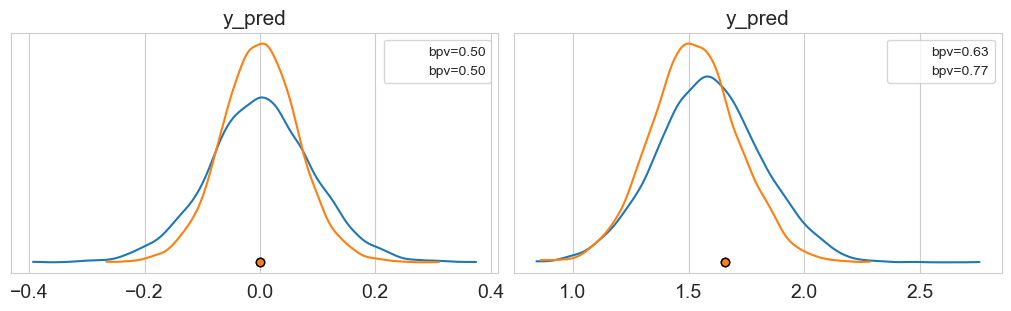

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

colors = ["C0", "C1"]
titles = ["mean", "interquartil range"]
models = ["lineal", "order 2"]
idatas = [sample_l, sample_p]

def iqr(x, axis=-1):
    return np.subtract(*np.percentile(x, [75, 25], axis=axis))

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat="mean", ax=ax[0], color=c)

for idata, c in zip(idatas, colors):
    az.plot_bpv(idata, kind="t_stat", t_stat=iqr, ax=ax[1], color=c)


Байесовские p-значения вычисляются при сравнении имитационных данных с реальными данными. Для обоих наборов данных вычислены обобщающие статистические характеристики (среднее значение и интерквартильный размах в рассматриваемом примере), затем было определено пропорциональное отношение количества случаев, когда обобщенные статистические характеристики больше или равны статистическим характеристикам, вычисленным по реальным данным. Если реальные и имитационные данные согласованы, то мы должны ожидать p-значение, близкое к 0.5, в противном случае наблюдается отклонение прогнозируемого апостериорного распределения.

Байесовский p-value это вероятность получения имитационной статистической характеристики $T_{sim}$ , большей или равной, чем статистическая характеристика реальных данных $T_{obs}$. Здесь $T$ может быть практически любой характеристикой, которая предоставляет возможность получения обобщенного результата по исследуемым данным.

На схеме указаны среднее значение на левой диаграмме и для размаха IRQ на правой диаграмме. 

Рассматриваемые здесь p-value являются байесовскими, потому что для распределения сэмплирования (выборки) мы используем прогнозируемое апостериорное распределение. Также отметим, что здесь мы не принимаем во внимание какие-либо нулевые гипотезы (предположения), фактически мы имеем полное апостериорное распределение для $\theta$ и рассматриваем только условия, связанные с наблюдаемыми реальными данными. 

Еще одно отличие состоит в том, что мы не используем какое-либо предварительно определенное пороговое значение для объявления статистической значимости, а кроме того, не проводим проверки гипотез – мы лишь пытаемся найти числовое значение для оценки соответствия прогнозируемого апостериорного распределения наблюдаемому исходному набору данных.